In [79]:
import os
import cv2
import yaml
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchview import draw_graph
from torchvision import transforms
from torchmetrics import JaccardIndex
from torch.utils.data import DataLoader
from utils import CustomDataset, compute_stats, map_to_class, get_network, generate_graph, save_args

ImportError: cannot import name 'save_args' from 'utils' (/Users/ericmonzon/Desktop/personal projects/deeplabv3-finetune-trial2/src/utils/__init__.py)

In [2]:
data_dir = os.path.join('..', 'data')
train_img_dir = os.path.join(data_dir, 'train', 'images')
train_mask_dir = os.path.join(data_dir, 'train', 'masks')

mean, std = compute_stats(train_img_dir)

train_dataset = CustomDataset(
    img_dir=train_img_dir, mask_dir=train_mask_dir,
    mean=mean, std=std
)

train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=False, drop_last=False)

In [3]:
img, mask = next(iter(train_loader))

In [11]:
torch.unique(map_to_class(mask))

tensor([0, 1, 2, 3])

In [6]:
map_to_class(mask).shape

torch.Size([2, 512, 512])

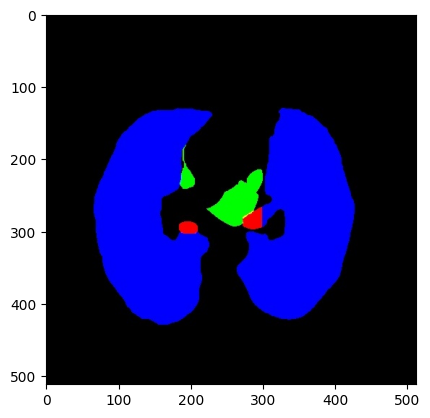

In [8]:
plt.imshow(mask[1].squeeze(0).permute(1, 2, 0).numpy())

In [12]:
model = get_network(backbone='resnet50', num_classes=4)

model

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [8]:
# destination = os.path.join('..', 'assets', 'visuals')
# generate_graph(model, destination)

In [31]:
def get_iou(pred, target, num_classes, device):
    jaccard = JaccardIndex(task="multiclass", num_classes=num_classes, average="macro").to(device)
    miou = jaccard(pred, target)

    return miou


In [37]:
num_classes = 4

device = 'mps'
lr = 0.0001
weight_decay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [39]:
model = model.to(device)
model.train()
running_loss = 0
running_miou = 0

for (img, mask) in tqdm(train_loader, desc="Training Model."):
    optimizer = optimizer.zero_grad()
    
    img = img.to(device)
    mapped_mask = map_to_class(mask).to(device)

    logits = model(img)["out"]
    probabilities = F.softmax(logits, dim=1)

    loss = criterion(logits, mapped_mask)
    pred = torch.argmax(probabilities, dim=1)
    
    miou = get_iou(pred, mapped_mask, num_classes=num_classes, device=device)
    running_loss += loss.item()
    running_miou += miou.item()

    loss.backward()
    optimizer.step()

    break

epoch_loss = running_loss / len(train_loader)
epoch_miou = running_miou / len(train_loader)


Training Model.:   0%|          | 0/5848 [00:01<?, ?it/s]


In [41]:
print("running loss:", running_loss)
print("running_miou:", running_miou)

running loss: 1.667466163635254
running_miou: 0.006637930870056152


In [42]:
print(type(running_miou))

<class 'float'>


In [29]:
criterion(logits, mapped_mask)

tensor(1.6646, device='mps:0', grad_fn=<NllLoss2DBackward0>)

In [34]:
get_iou(pred, mapped_mask, num_classes=4, device=device)

tensor(0.0073, device='mps:0')

In [16]:
logits['out'].shape

torch.Size([2, 4, 512, 512])

In [22]:
torch.argmax(probabilities, dim=1).shape

torch.Size([2, 512, 512])

In [14]:
mapped_mask.shape

torch.Size([1, 512, 512])

In [43]:
type(miou)

torch.Tensor

In [44]:
mapped_mask.shape

torch.Size([2, 512, 512])

In [64]:
type(miou.detach().cpu().item())

float

In [59]:
loss

tensor(1.6675, device='mps:0', grad_fn=<NllLoss2DBackward0>)

In [65]:
type(optimizer)

torch.optim.adam.Adam

In [83]:
def get_args(arg_dir):
    with open(arg_dir, "r") as f:
        args = yaml.safe_load(f)

    return args

def save_args(args, dest):
    with open(dest, "w") as f:
        yaml.dump(args, f)

In [87]:
arg_dir = os.path.join("config", "train_config.yaml")
args = get_args(arg_dir)

In [88]:
args

{'num_classes': 4,
 'epochs': 50,
 'batch_size': 20,
 'backbone': 'resnet50',
 'learning_rate': 0.0001,
 'weight_decay': 0.0001}

In [78]:
print(type(args['weight_decay']))

<class 'float'>
